<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/weights/weight_initialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

# step 1: import & process data

In [133]:
# import dataset (comes with colab):
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',') # np array
print(data.shape)

# extract labels, then remove the labels from data:
labels = data[:,0]
data   = data[:,1:]

# normalize the data:
dataNorm = data / np.max(data) # np array

(20000, 785)


👆 20000 samples(numbers), 28x28 pixels + 1 label

In [134]:
# 1. np array -> torch tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# 2. use scikitlearn to split data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

# 3. torch tensor -> torch dataset obj (combine)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# 4. torch dataset obj -> torch dataloader obj (shuffle)
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.Size([18000, 784]) torch.Size([18000]) torch.Size([2000, 784]) torch.Size([2000])


# step 2: create the DL model

In [135]:
def createTheMNISTNet():

  # create a class for the model:
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### fully connected hidden layers
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance:
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [136]:
# check the weight tensor for fc1 layer:

tmpnet = createTheMNISTNet()[0] # net only
print(tmpnet, "\n")
print(tmpnet.fc1.weight.data) # weight tensor for fc1 layer

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
) 

tensor([[-0.1065,  0.1186, -0.1066,  ..., -0.0706, -0.0887, -0.0588],
        [-0.0055, -0.0914, -0.1194,  ..., -0.0596, -0.0533,  0.0094],
        [-0.0809, -0.0798, -0.0912,  ...,  0.0101,  0.0261,  0.0353],
        ...,
        [-0.0126, -0.0566, -0.0744,  ..., -0.0732,  0.0863, -0.0339],
        [-0.0743,  0.0723, -0.1250,  ..., -0.0474, -0.0667,  0.1193],
        [ 0.0294, -0.0757,  0.0267,  ...,  0.0457,  0.0699, -0.0922]])


# step 3: create a function to train the model

In [137]:
def function2trainTheModel(net,lossfun,optimizer):

  numepochs = 10

  # initialize
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    net.train()

    # initialize batch loss and acc
    batchLoss = []
    batchAcc  = []

    # loop over training batches
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      # record batch loss
      batchLoss.append(loss.item())

      # backprop
      optimizer.zero_grad() # zero out gradients from the prev iteration
      loss.backward() # calculates gradients of the loss
      optimizer.step() # update weights based on the calculated gradients

      # compute accuracy & record
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      # print(matches.shape) # torch.Size([32])
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # average training losses and acc across batches
    losses[epochi] = np.mean(batchLoss)
    trainAcc.append( np.mean(batchAcc) )

    net.eval() # switch to eval mode

    # test accu
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# step 4: run the model & show results (baseline)

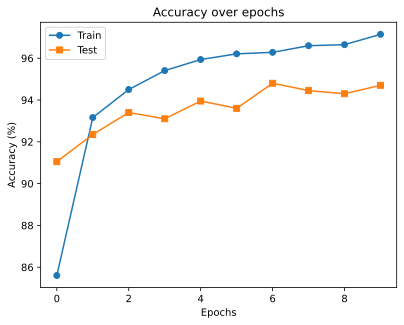

In [138]:
# Run the model without changing the weights; this will be the baseline performance.

net_base,lossfun,optimizer = createTheMNISTNet()
trainAcc_base,testAcc_base,losses,net_base = function2trainTheModel(net_base,lossfun,optimizer)

# plot the results
plt.plot(range(len(trainAcc_base)),trainAcc_base,'o-', range(len(testAcc_base)),testAcc_base ,'s-')
plt.legend(['Train','Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

👆 There are a few possible reasons why the test accuracy may go down in large epochs in DL:
1. overfitting: the model performs well on the training data but does not generalize to unseen data.
2. insufficient training data: as more data can help improve generalization.
3. the model is learning redundant features or features that don't improve accuracy (eg: all samples come from the same country, then the "origin" feature is redundant, and would not improve the accuracy of the model).

# step 5: set weight matrix of fc1 to all 0s

In [139]:
# create a model instance and return
net_zero,lossfun,optimizer = createTheMNISTNet()

# change weight matrix of fc1 to all 0s before training
net_zero.fc1.weight.data = torch.zeros_like( net_zero.fc1.weight ) # create a all-0 matrix that is in same shape of the input matrix

# confirm
W_fc1 = net_zero.fc1.weight.data
print(W_fc1.shape)
print(W_fc1)

torch.Size([32, 64])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [140]:
# run the model once again with all-0 fc1 weight matrix:
trainAcc_zero,testAcc_zero,losses,net_zero = function2trainTheModel(net_zero,lossfun,optimizer)

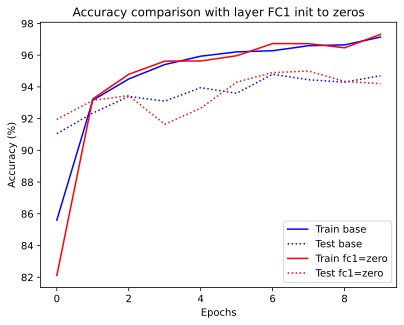

In [141]:
# view all results in one plot:

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_zero)),trainAcc_zero,'r-', range(len(testAcc_zero)),testAcc_zero ,'r:')
plt.legend(['Train base','Test base','Train fc1=zero','Test fc1=zero'])
plt.title('Accuracy comparison with layer FC1 init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

👆 actually the model with the first hidden layer weights set to zero still learns.

tensor([[ 1.2697,  0.4987, -0.4906,  ...,  0.2189,  0.6463, -0.3198],
        [ 0.1868, -0.7308, -0.3133,  ..., -0.4464, -0.0139, -0.3592],
        [-0.0595, -0.0845, -0.0758,  ..., -0.0846, -0.0780, -0.0844],
        ...,
        [ 0.0913, -0.3156, -0.3224,  ..., -0.3212,  0.1010, -0.1596],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


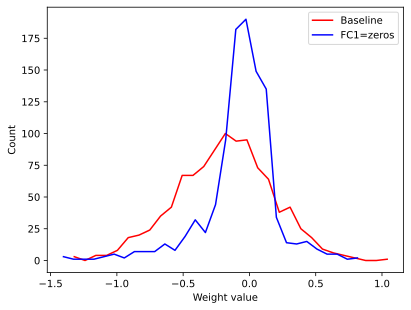

In [142]:
# Are the weights still zeros after training?
print(net_zero.fc1.weight.data)

# show the distributions in a histogram
y,x = np.histogram(net_base.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_zero.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='FC1=zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

# step 6:  set all learnable parameters to 0s & repeat the expt

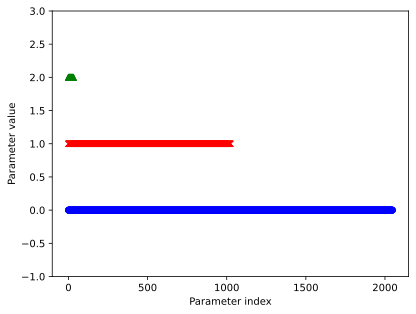

In [143]:
net_allzero,lossfun,optimizer = createTheMNISTNet() # create a fresh model instance and return params

# loop over parameters and set them all to zeros
for p in net_allzero.named_parameters():
  p[1].data = torch.zeros_like( p[1].data )

# confirm for a few select parameters (y-axis offset for visibility)
# just add a y-axis offset for visibility
plt.plot(0+net_allzero.fc1.weight.data.flatten(),'bo')
plt.plot(1+net_allzero.fc2.weight.data.flatten(),'rx')
plt.plot(2+net_allzero.fc1.bias.data.flatten(),'g^')
plt.xlabel('Parameter index')
plt.ylim([-1,3])
plt.ylabel('Parameter value')
plt.show()

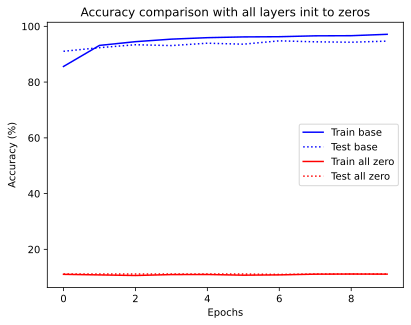

In [144]:
# run the model and show the results
trainAcc_allzero,testAcc_allzero,losses,net_allzero = function2trainTheModel(net_allzero,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allzero)),trainAcc_allzero,'r-', range(len(testAcc_allzero)),testAcc_allzero ,'r:')
plt.legend(['Train base','Test base','Train all zero','Test all zero'])
plt.title('Accuracy comparison with all layers init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

👆 The model will NOT learn if all learnable parameters are set to 0s.  

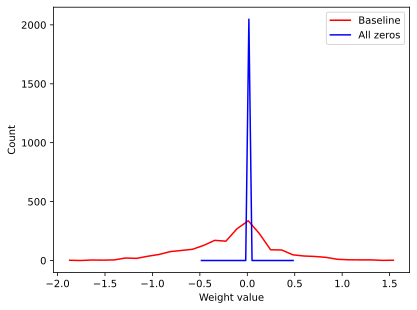

In [145]:
# show the distributions in a histogram
y,x = np.histogram(net_base.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_allzero.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='All zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

👆 When all of the weights from the entire model are initialized to zero, nothing changes during learning (not a single weight has changed in value).

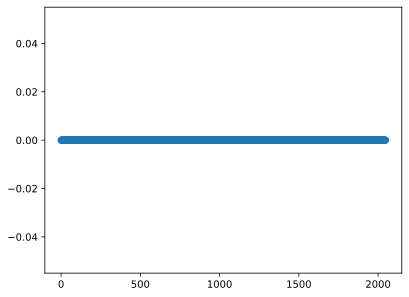

In [146]:
# 😱 Not even a single non-zero weight value?!?!!?!!??
plt.plot(net_allzero.fc1.weight.data.flatten(),'o');

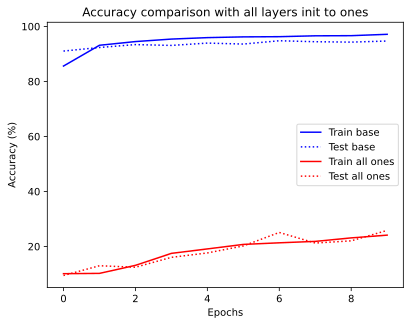

In [147]:
# Maybe zero is problematic. What about initializing to 1's?

net_allone,lossfun,optimizer = createTheMNISTNet()

for p in net_allone.named_parameters():
  p[1].data = torch.zeros_like( p[1].data ) + 1 # set to all 1s
  # p[1].data = torch.zeros( p[1].data.shape ) + 1 # equivalent

trainAcc_allone,testAcc_allone,losses,net_allone = function2trainTheModel(net_allone,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allone)),trainAcc_allone,'r-', range(len(testAcc_allone)),testAcc_allone ,'r:')
plt.legend(['Train base','Test base','Train all ones','Test all ones'])
plt.title('Accuracy comparison with all layers init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

👆 Got some learning. May get up to 40 or 50% accuracy if trained for a million epochs. But not efficient for sure!

Conclusions:
1. Models cannot learn (or learn well) when all trainable parameters are initialized to the same value.
2. Models can learn as long as some trainable parameters are initialized to different values.